<a href="https://colab.research.google.com/github/gabgovar/Exploracao_Pre-Processamento_de_dados_com_PySpark/blob/main/GPU_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install numba
! find / -iname 'libdevice'
! find / -iname 'libnvvm.so'

find: ‘/proc/30/task/30/net’: Invalid argument
find: ‘/proc/30/net’: Invalid argument
/usr/local/lib/python3.7/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-11.0/nvvm/libdevice
/usr/local/cuda-10.1/nvvm/libdevice
/usr/local/cuda-11.1/nvvm/libdevice
find: ‘/proc/30/task/30/net’: Invalid argument
find: ‘/proc/30/net’: Invalid argument
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so
/usr/local/cuda-11.0/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so
/usr/local/cuda-11.1/nvvm/lib64/libnvvm.so


## **INSTALANDO AS BIBLIOTECAS**

In [4]:
%matplotlib inline
from matplotlib import pyplot as pip
import numpy as np
import math
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from pylab import imshow, show
from timeit import default_timer as timer

Mandelbort

Mandelbrot sem GPU

In [5]:
def mandel(x, y, max_iters):
    """"
      Dadas as partes real e imaginária de um número complexo, 
      determine se ele é um candidato a membro do conjunto de mandelbrot 
      dado um número fixo de iterações
    """

    c = complex (x ,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i
    
    return max_iters

In [11]:
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    widht = image.shape[1]

    pixel_size_x = (max_x - min_x) / height
    pixel_size_y = (max_y - min_y) / widht

    for x in range(widht):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

Mandelbot created in 4.228622 s


<function matplotlib.pyplot.show>

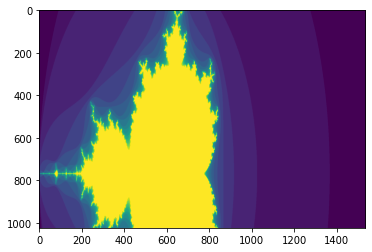

In [12]:
image = np.zeros((1024, 1536), dtype= np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
dt = timer() - start

print("Mandelbot created in %f s" % dt)
imshow(image)
show

Run Mandelbot Numba

In [13]:
@jit
def mandel(x, y, max_iters):
    """"
      Dadas as partes real e imaginária de um número complexo, 
      determine se ele é um candidato a membro do conjunto de mandelbrot 
      dado um número fixo de iterações
    """

    c = complex (x ,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i
    
    return max_iters

@jit

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    widht = image.shape[1]

    pixel_size_x = (max_x - min_x) / height
    pixel_size_y = (max_y - min_y) / widht

    for x in range(widht):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

Mandelbot created in 0.400088 s


<function matplotlib.pyplot.show>

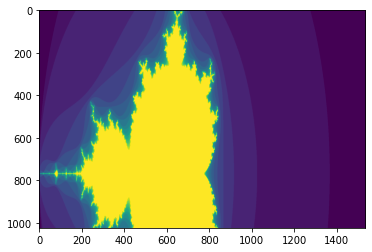

In [14]:
image = np.zeros((1024, 1536), dtype= np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
dt = timer() - start

print("Mandelbot created in %f s" % dt)
imshow(image)
show

CUDA GPU Mandelbrot

In [16]:
mandel_gpu = cuda.jit(restype = uint32, argtypes= [f8, f8, uint32], device = True)(mandel)

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:69: NumbaDeprecationWarning: Deprecated keyword argument `argtypes`. Signatures should be passed as the first positional argument.
  warn(msg, category=NumbaDeprecationWarning)


In [19]:
@cuda.jit(argtypes=[f8, f8, f8, f8, uint8[:,:], uint32])
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    widht = image.shape[1]

    pixel_size_x = (max_x - min_x) / widht
    pixel_size_y = (max_y - min_y) / height

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;

    for x in range(startX, widht, gridX):
        real = min_x + x * pixel_size_x
        for y in range(startY, height, gridY):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = mandel_gpu(real, imag, iters)

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:69: NumbaDeprecationWarning: Deprecated keyword argument `argtypes`. Signatures should be passed as the first positional argument.
  warn(msg, category=NumbaDeprecationWarning)


Mandelbot created in 0.045634 s


<function matplotlib.pyplot.show>

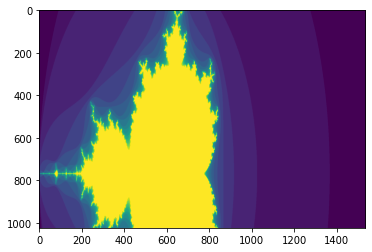

In [20]:
image = np.zeros((1024, 1536), dtype= np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
dt = timer() - start

print("Mandelbot created in %f s" % dt)
imshow(image)
show

Cuda vetorização

In [31]:


from numba import (cuda, vectorize)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from functools import wraps
from time import time

def real_estate_df():
    """30 anos de preços de habitação"""

    df = pd.read_csv("https://raw.githubusercontent.com/gabgovar/cloud-data-analysis-at-scale/main/data/Zip_Zhvi_SingleFamilyResidence.csv")
    df.rename(columns={"RegionName":"ZipCode"}, inplace=True)
    df["ZipCode"]=df["ZipCode"].map(lambda x: "{:.0f}".format(x))
    df["RegionID"]=df["RegionID"].map(lambda x: "{:.0f}".format(x))
    return df

def numerical_real_estate_array(df):
    """Converte df em matriz numérica numpy"""

    columns_to_drop = ['RegionID', 'ZipCode', 'City', 'State', 'Metro', 'CountyName']
    df_numerical = df.dropna()
    df_numerical = df_numerical.drop(columns_to_drop, axis=1)
    return df_numerical.values

def real_estate_array():
    """Retorna Matriz de Imóveis"""

    df = real_estate_df()
    rea = numerical_real_estate_array(df)
    return np.float32(rea)


@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

def cuda_operation():
    """Executa operações vetorizadas na GPU"""

    x = real_estate_array()
    y = real_estate_array()

    print("Movendo cálculos para a memória da GPU")
    x_device = cuda.to_device(x)
    y_device = cuda.to_device(y)
    out_device = cuda.device_array(
        shape=(x_device.shape[0],x_device.shape[1]), dtype=np.float32)
    print(x_device)
    print(x_device.shape)
    print(x_device.dtype)

    print("Calculando na GPU")
    add_ufunc(x_device,y_device, out=out_device)

    out_host = out_device.copy_to_host()
    print(f"Cálculos da GPU \n {out_host}")

cuda_operation()

Movendo cálculos para a memória da GPU
(10015, 259)
float32
Calculando na GPU
Cálculos da GPU 
 [[2.0000e+00 8.4160e+05 8.4700e+05 ... 2.1086e+06 2.0970e+06 2.0888e+06]
 [4.0000e+00 1.0848e+06 1.0934e+06 ... 3.0316e+06 3.0398e+06 3.0506e+06]
 [6.0000e+00 1.4180e+05 1.4240e+05 ... 2.2760e+05 2.2700e+05 2.2660e+05]
 ...
 [3.0554e+04 1.9780e+05 1.9620e+05 ... 4.3960e+05 4.4000e+05 4.4080e+05]
 [3.0560e+04 1.7340e+05 1.7500e+05 ... 3.8140e+05 3.8460e+05 3.8720e+05]
 [3.0562e+04 5.0700e+05 5.0800e+05 ... 1.5672e+06 1.5590e+06 1.5484e+06]]
